In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,precision_score,recall_score,f1_score
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder,TargetEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.feature_selection import mutual_info_classif
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.inspection import permutation_importance

In [2]:
features = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", 
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", 
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", 
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", 
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", 
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", 
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate","Label"
]

training_data = pd.read_csv('/Users/younishubsey/desktop/kddcup.data_10_percent.csv',header = None)
# giving the columns the feature names
training_data.columns = features

test_data = pd.read_csv('/Users/younishubsey/desktop/corrected.csv',header = None)
test_data.columns = features

In [3]:
test_data = test_data[test_data["Label"].isin(training_data["Label"].unique())]
print(test_data.shape)

(292300, 42)


In [4]:
attack_categories={
'normal.' : 'Normal',

'back.' : 'DoS', 'land.' : 'DoS', 'neptune.' : 'DoS', 'pod.' : 'DoS', 'smurf.' : 'DoS','teardrop.' : 'DoS',

'buffer_overflow.':'U2R', 'loadmodule.':'U2R', 'perl.':'U2R', 'rootkit.': 'U2R',

'ftp_write.' : 'R2L' , 'guess_passwd.':'R2L', 'imap.':'R2L', 'multihop.':'R2L', 'phf.':'R2L', 'spy.':'R2L', 'warezclient.':'R2L', 'warezmaster.':'R2L',

'ipsweep.':'Probing', 'nmap.':'Probing', 'portsweep.':'Probing', 'satan.': 'Probing'
}

training_data['attack_sections']=training_data['Label'].map(attack_categories)
test_data['attack_sections']=test_data['Label'].map(attack_categories)

In [5]:

training_data['attack_sections'] = training_data['Label'].map(attack_categories)
test_data['attack_sections'] = test_data['Label'].map(attack_categories)

print(training_data['attack_sections'].value_counts())

attack_sections
DoS        391458
Normal      97278
Probing      4107
R2L          1126
U2R            52
Name: count, dtype: int64


In [6]:
training_data = training_data[training_data['attack_sections'] != 'U2R']
test_data = test_data[test_data['attack_sections'] != 'U2R']

In [7]:
from sklearn.preprocessing import LabelEncoder
our_categorical_columns = ["Label","attack_sections"]
label_encoder = LabelEncoder()
for col in our_categorical_columns:
    training_data[col]=label_encoder.fit_transform(training_data[col])
    test_data[col] = label_encoder.transform(test_data[col])

In [8]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = ["protocol_type", "service", "flag"]

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
train_ohe = encoder.fit_transform(training_data[categorical_features])
test_ohe = encoder.transform(test_data[categorical_features])

train_encoded_df = pd.DataFrame(train_ohe, columns=encoder.get_feature_names_out(categorical_features))
test_encoded_df = pd.DataFrame(test_ohe, columns=encoder.get_feature_names_out(categorical_features))

training_data = training_data.drop(columns=categorical_features).reset_index(drop=True)
test_data = test_data.drop(columns=categorical_features).reset_index(drop=True)

training_data = pd.concat([training_data, train_encoded_df], axis=1)
test_data = pd.concat([test_data, test_encoded_df], axis=1)

In [9]:
x_train =training_data.drop(columns=['Label','attack_sections'])
y_train = training_data['attack_sections']
x_test = test_data.drop(columns = ["Label","attack_sections"])
y_test = test_data["attack_sections"]

In [10]:
feature_drop = [
    
    'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login',

  
    'srv_count', 'srv_serror_rate', 'srv_rerror_rate',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
]

x_train_select = x_train.drop(columns=feature_drop)
x_test_select = x_test.drop(columns=feature_drop)

In [11]:
# sampling = {2:40000,3:391400}
# smote_tomek = SMOTETomek(sampling_strategy = sampling,random_state=42)
# X_resampled, y_resampled = smote_tomek.fit_resample(x_train_select, y_train)

In [12]:
#sampling = {2:40000,3:391400}
smote_tomek = SMOTETomek(sampling_strategy = "not majority",random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(x_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_resampled)  
X_test_scaled = scaler.transform(x_test) 

In [14]:
# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_resampled)  
# X_test_scaled = scaler.transform(x_test) 

In [15]:
# our_scaler = StandardScaler()
# #applying the transform on our continous columns
# X_train_scaled = our_scaler.fit_transform(X_resampled)
# X_train_scaled
# X_test_scaled = our_scaler.transform(x_test_select)

In [16]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(128,64,32),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init = 0.001,
    max_iter=1000,
    batch_size=128,
    alpha=0.1,
    n_iter_no_change=40,
    early_stopping = True,
    random_state=42
)

mlp.fit(X_resampled, y_resampled)

MLPClassifier(alpha=0.1, batch_size=128, early_stopping=True,
              hidden_layer_sizes=(128, 64, 32), learning_rate='adaptive',
              max_iter=1000, n_iter_no_change=40, random_state=42)


 Classification Report (Top Features):

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    223298
           1       0.93      0.97      0.95     60593
           2       0.76      0.98      0.86      2377
           3       0.39      0.21      0.28      5993

    accuracy                           0.97    292261
   macro avg       0.77      0.79      0.77    292261
weighted avg       0.97      0.97      0.97    292261



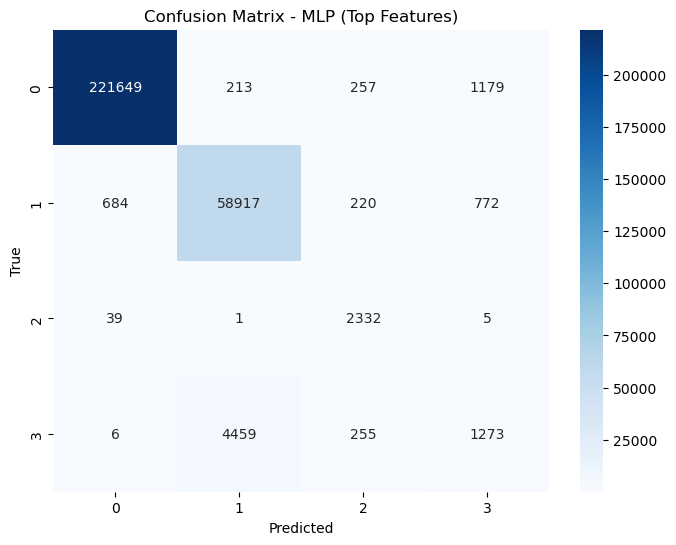

In [17]:
y_pred = mlp.predict(x_test)

print("\n Classification Report (Top Features):\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Top Features)")
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    223298
           1       0.91      0.73      0.81     60593
           2       0.83      0.98      0.90      2377
           3       0.09      0.28      0.14      5993

    accuracy                           0.92    292261
   macro avg       0.71      0.75      0.71    292261
weighted avg       0.96      0.92      0.94    292261



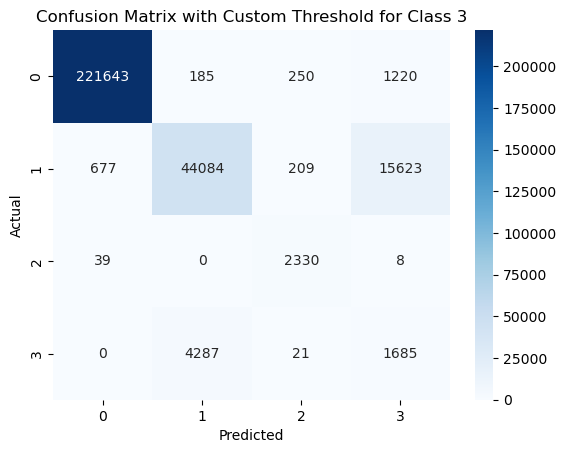

In [18]:
y_proba = mlp.predict_proba(x_test)

y_pred_custom = []
for prob in y_proba:
    if prob[3] >= 0.15:  # lower the threshold for class 3
        y_pred_custom.append(3)
    else:
        y_pred_custom.append(np.argmax(prob))

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix with Custom Threshold for Class 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
y_proba = mlp.predict_proba(x_test)
y_pred_custom = []

for prob in y_proba:
    if prob[3] >= 0.2:  # try 0.25, 0.3, 0.35 too
        y_pred_custom.append(3)
    else:
        y_pred_custom.append(np.argmax(prob))

print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    223298
           1       0.91      0.74      0.81     60593
           2       0.82      0.98      0.89      2377
           3       0.09      0.27      0.13      5993

    accuracy                           0.92    292261
   macro avg       0.70      0.74      0.71    292261
weighted avg       0.96      0.92      0.94    292261



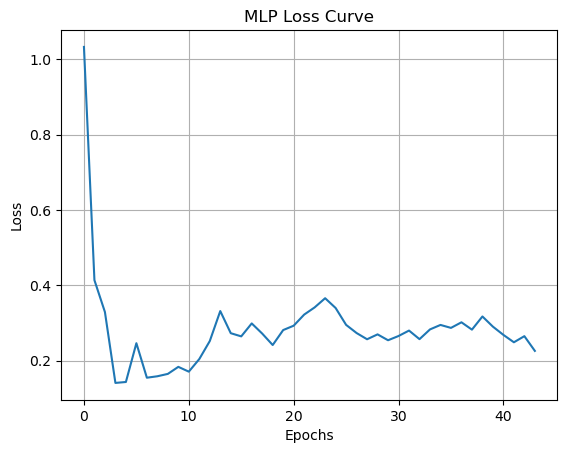

In [20]:
import matplotlib.pyplot as plt
plt.plot(mlp.loss_curve_)
plt.title("MLP Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()


In [21]:
result = permutation_importance(mlp, X_test_scaled, y_test, scoring='f1_macro', n_repeats=10, random_state=42)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-

/var/folders/2d/7dqps2_n0zx5l2_fx7bz690h0000gn/T/ipykernel_73455/1470015824.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='Blues_d')


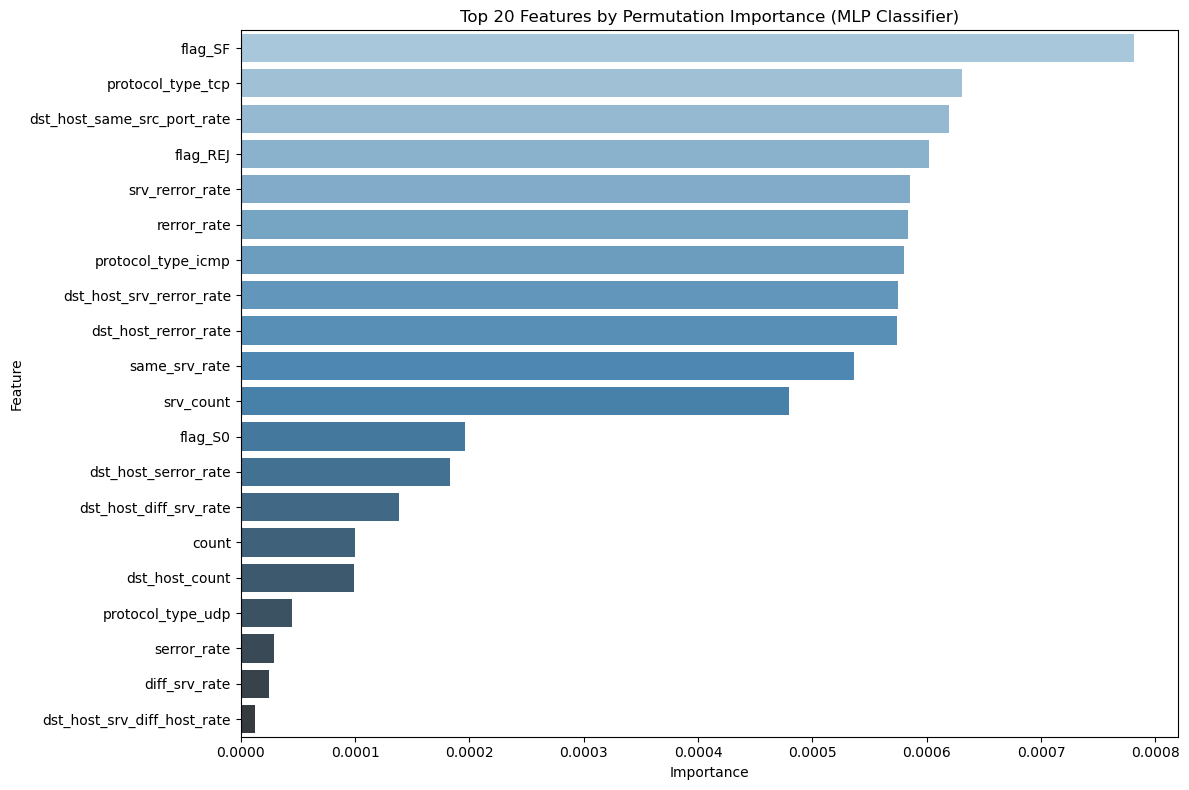

In [22]:

feature_names = x_train.columns 
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='Blues_d')
plt.title("Top 20 Features by Permutation Importance (MLP Classifier)")
plt.tight_layout()
plt.show()

In [23]:
# threshold = 0.05
# important_features_df = importance_df[importance_df['Importance'] >= threshold]

# # Step 5: Sort for visualization
# important_features_df = important_features_df.sort_values(by='Importance', ascending=False)

# # Step 6: Plot
# plt.figure(figsize=(10, 6))
# plt.barh(important_features_df['Feature'], important_features_df['Importance'])
# plt.xlabel("Permutation Importance")
# plt.title(f"Top Features (Threshold ≥ {threshold}) - MLPClassifier")
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

In [24]:
# threshold = 0.000005
# important_features_df = importance_df[importance_df['Importance'] >= threshold]
# important_features_df = important_features_df.sort_values(by="Importance", ascending=False)

# # Step 5: Get selected top features
# top_features = important_features_df["Feature"].tolist()

# print(f"\n🔹 Top Features (Threshold ≥ {threshold}):")
# print(top_features)

# # Step 6: Reduce datasets to top features
# selected_indices = [x_train.columns.get_loc(f) for f in top_features]
# X_train_top = X_train_scaled[:, selected_indices]
# X_test_top = X_test_scaled[:, selected_indices]

In [25]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=x_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=x_test.columns)

# Step 2: Select only the top 20 features
top_20_features = importance_df.head(23)['Feature'].tolist()
X_train_topp = X_train_scaled_df[top_20_features]
X_test_topp = X_test_scaled_df[top_20_features]


In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique class labels
classes = np.unique(y_resampled)

# Compute weights
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)
class_weights = dict(zip(classes, weights))

print("Class Weights:", class_weights)

Class Weights: {0: 0.9999067578821522, 1: 1.0001009254480324, 2: 0.9999016492274994, 3: 1.0000907042224731}


In [27]:
sample_weights = np.array([class_weights[label] for label in y_resampled])

In [28]:
sample_weight=sample_weights

In [29]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_resampled)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)
class_weight_dict = dict(zip(classes, class_weights))
print("New Class Weights:", class_weight_dict)


New Class Weights: {0: 0.9999067578821522, 1: 1.0001009254480324, 2: 0.9999016492274994, 3: 1.0000907042224731}


In [30]:
# sample_weights = np.array([adjusted_weights[label] for label in y_resampled])



 Classification Report (Top Features):

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    223298
           1       0.96      0.96      0.96     60593
           2       0.85      0.86      0.86      2377
           3       0.69      0.84      0.76      5993

    accuracy                           0.98    292261
   macro avg       0.88      0.92      0.89    292261
weighted avg       0.98      0.98      0.98    292261



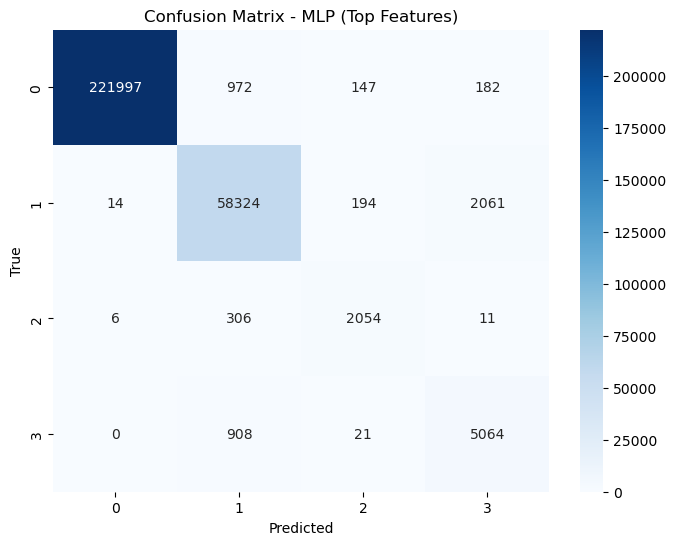

In [90]:
mlp_finall = MLPClassifier(
     hidden_layer_sizes=(128,64,32),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init = 0.01,
    max_iter=1000,
    batch_size=128,
    alpha=0.1,
    n_iter_no_change=40,
    early_stopping = True,
    random_state=42
)
mlp_finall.fit(X_train_topp, y_resampled)

# Step 8: Evaluate
y_pred = mlp_finall.predict(X_test_topp)

print("\n Classification Report (Top Features):\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Top Features)")
plt.show()

In [32]:
import pandas as pd

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report dictionary into a pandas DataFrame
report_df = pd.DataFrame(report).T  # Transpose to make it more readable
print(report_df)

              precision    recall  f1-score        support
0              0.999980  0.665967  0.799489  223298.000000
1              0.000000  0.000000  0.000000   60593.000000
2              0.016538  0.998738  0.032537    2377.000000
3              0.000000  0.000000  0.000000    5993.000000
accuracy       0.516945  0.516945  0.516945       0.516945
macro avg      0.254129  0.416176  0.208007  292261.000000
weighted avg   0.764155  0.516945  0.611103  292261.000000


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
report_df.to_csv('classification_report.csv')


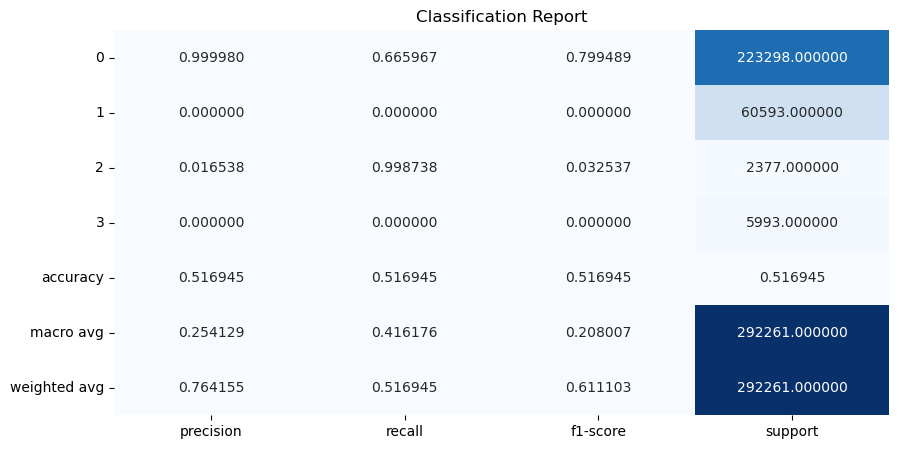

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the table as an image
plt.figure(figsize=(10, 5))
sns.heatmap(report_df, annot=True, fmt='f', cmap="Blues", cbar=False)
plt.title('Classification Report')
plt.savefig('classification_report_image.png', bbox_inches="tight")


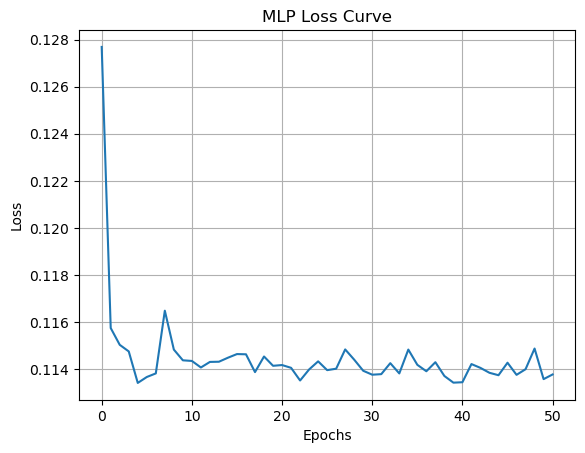

In [92]:
import matplotlib.pyplot as plt
plt.plot(mlp_finall.loss_curve_)
plt.title("MLP Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()